# MiniLab1 -
## AirBnB Listings for Los Angeles Area
### Jason McDonald, Miguel Bonilla, Zachary Bunn

This notebook explores the application of logistic regression, Support Vector Machine (SVM), and Gradient Optimization as classifiers to Superhost status of AirBnB listings (a binary categorical response).

**Table of Contents**

- [Data Wrangling](#Data-Wrangling)
- [Create Models](#Create-Models)
  * [Logistic Regression](#Logistic-Regression-Model)
  * [Support Vector Machine Model](#Support-Vector-Machine-Model)
- [Model Advantages](#Model-Advantages)
- [Interpret Feature Importance](#Interpret-Feature-Importance)
- [Interpret Support Vectors](#Interpret-Support-Vectors)
  

#### Data Wrangling
First, we begin by cleaning up the data and imputing missing values for certain variables.

In [1]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv("https://media.githubusercontent.com/media/boneeyah/DS7331_Group/main/Data_Files/airbnb_los_angeles.csv")
#df = pd.read_csv("Data_Files/airbnb_los_angeles.csv")

In [2]:
# drop variables which won't be useful for the classification model
for col in [
    'listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate',
    'host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','bathroom_text','host_listings_count','host_neighbourhood','bathrooms','minimum_minimum_nights',
    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60',
    'availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_accuracy','review_scores_communication','review_scores_cleanliness',
    'review_scores_checkin','review_scores_value','review_scores_location','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','reviews_per_month','neighbourhood','neighbourhood_group_cleansed', 'first_review','last_review','minimum_nights','maximum_nights','license','host_total_listings_count'
]:
    if col in df:
        del df[col]

In [3]:
# remove nulls
df = df[~df.review_scores_rating.isnull() & ~df.bathrooms_text.isnull() & ~df.host_since.isnull() & ~df.host_location.isnull()]

## getting property type from string
types = ['Private room', 'Entire', 'Room in hotel','Room','Shared room']
pat = '|'.join(r"\b{}\b".format(x) for x in types)

df['property_type']= df['property_type'].str.extract('('+ pat + ')', expand = False)
df['property_type'] = (df.property_type.
                       fillna(value = 'other').
                       replace(['Entire','Room in hotel'],['Entire unit','Hotel room']))
df['property_type'].value_counts()

Entire unit     22767
Private room     8081
Shared room       510
Room              401
other             298
Hotel room        272
Name: property_type, dtype: int64

In [4]:
# impute values based on median
df['beds'] = df[['accommodates','beds']].groupby(by = 'accommodates').transform(lambda grp: grp.fillna(grp.median()))
df_grouped = df.groupby(by = ['property_type','beds'])
df_imputed = df_grouped[['beds','bedrooms']].transform(lambda grp: grp.fillna(grp.median()))

index = df_imputed[df_imputed.bedrooms.isnull()].index
df = df.drop(index= index)

df['imputed']=df_imputed[['bedrooms']]

# replace 'bedrooms' column with imputed column and deleting the duplicated column
df['bedrooms'] = df['imputed']
del df['imputed']

In [5]:
## now fixing dtypes for attributes
df['host_since'] = pd.to_datetime(df.host_since)
df['price'] = df['price'].replace('[\$,]','',regex = True).astype(float)
df['bathrooms_text'] = df['bathrooms_text'].replace(['Half-bath', 'Shared half-bath', 'Private half-bath'],['0.5 bath','0.5 shared bath', '0.5 private bath'])
df_bathrooms = df['bathrooms_text'].str.split(n=1, expand=True).rename(columns = {0:'bathroom_number',1:'bathroom_type'})
df_bathrooms['bathroom_type'] = df_bathrooms.bathroom_type.fillna(value = 'bath')
df_bathrooms['bathroom_type'] = df_bathrooms['bathroom_type'].replace(['baths','shared baths'],['bath','shared bath'])
df_bathrooms['bathroom_number'] = df_bathrooms['bathroom_number'].astype('float')
df.insert(15, 'bathroom_number',df_bathrooms['bathroom_number'])
df.insert(16, 'bathroom_type', df_bathrooms['bathroom_type'])
del df['bathrooms_text']

In [6]:
### filter out price outliers
df = df[(df.beds<10) & (df.price<750)]

In [7]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              30580 non-null  int64         
 1   name                            30580 non-null  object        
 2   host_id                         30580 non-null  int64         
 3   host_name                       30580 non-null  object        
 4   host_since                      30580 non-null  datetime64[ns]
 5   host_location                   30580 non-null  object        
 6   host_is_superhost               30580 non-null  object        
 7   host_identity_verified          30580 non-null  object        
 8   neighbourhood_cleansed          30580 non-null  object        
 9   latitude                        30580 non-null  float64       
 10  longitude                       30580 non-null  float64       
 11  pr

In [8]:
# breakdown of categorical variables with number of levels (unique)
df.iloc[:,[1,3,5,6,7,8,11,12,15,18,20,23]].describe().T

,count,unique,top,freq
name,30580,29942,Boutique Hostel,46
host_name,30580,6604,David,249
host_location,30580,980,"Los Angeles, California, United States",10613
host_is_superhost,30580,2,f,20236
host_identity_verified,30580,2,t,26080
neighbourhood_cleansed,30580,302,Long Beach,1163
property_type,30580,6,Entire unit,21090
room_type,30580,4,Entire home/apt,21433
bathroom_type,30580,3,bath,22738
amenities,30580,28937,"[""Hangers"", ""First aid kit"", ""Heating"", ""Fire ...",40


This table shows the number of unique levels for categorical variables in our dataset, as well as the most common level of each variable along with its frequency count. From this table, we can see that about 1/3 of listings (10613/30580) correspond to a host who has Superhost status. Additionally the table shows that amenities has 28937 unique levels, given the way these are listed for each listing, a decission was made to drop the variable for this project.

# Create Models


To be able to use categorical variables when fitting our models, we will first encode these variables using LabelEncoder and OneHotEncoder, which convert variables into categorical variables represented by binary values of 0 and 1. LabelEncoder can be used to convert binary categories into binary values of 0 and 1 for each level of the original variable. OneHotEncoder can be used to covert variables with more than two categorical variables, by creating n-1 columns (where n corresponds to the number of levels in a category).

In [9]:
# Model will focus on classifying superhost status
# since we're encoding with binary response, we can use labelencoder from sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['host_is_superhost'] = label_encoder.fit_transform(df['host_is_superhost'])
print('host_is_superhost')
df.host_is_superhost.value_counts()

host_is_superhost


0    20236
1    10344
Name: host_is_superhost, dtype: int64

The value of 0 corresponds to the status of 'f' of the original variable, a quick check shows that the value matches that which was previously found (20236 for 'f').

In [10]:
## encoding binary categorical variables
# encode identity verified
df['host_identity_verified'] = label_encoder.fit_transform(df['host_identity_verified'])
print('host_identity_verified')
print(df.host_identity_verified.value_counts())

#encode has_availability
df['has_availability'] = label_encoder.fit_transform(df['has_availability'])
print('has_availability')
print(df.has_availability.value_counts())

#encode instant bookable
df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])
print('instant_bookable')
print(df.instant_bookable.value_counts())

host_identity_verified
1    26080
0     4500
Name: host_identity_verified, dtype: int64
has_availability
1    28785
0     1795
Name: has_availability, dtype: int64
instant_bookable
0    19767
1    10813
Name: instant_bookable, dtype: int64


Encoding the rest of the binary categorical variables similarly shows the new binary levels match the categorical levels of the original variables.

In order to gain more useful insight from host location, we made the decission to create a new feature to replace it based on whether the host is local or not. We utilized a new table containing 100+ neighborhoods in the Los Angeles area, and matched those to host location to determine if a host is local to the LA area. We then used LabelEncoder to covert it into binary values.

In [11]:
## changing host_location to a binary feature of is_local using a list of LA area neighborhoods that will be used to extract from location str
#los_angeles = pd.read_csv('Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = pd.read_csv('https://raw.githubusercontent.com/boneeyah/DS7331_Group/main/Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = los_angeles.iloc[:,0].tolist()

pattern = '|'.join(los_angeles)
df['host_is_local'] = df['host_location'].str.contains(pattern)

df['host_is_local'] = label_encoder.fit_transform(df['host_is_local'])
print('host_is_local')
df.host_is_local.value_counts()

host_is_local


0    19056
1    11524
Name: host_is_local, dtype: int64

With the newly created variable host_is_local replacing host_location, we now have a variable with 2 levels, as opposed to the original with over 900 categories.

To convert host_since from datetime to a useable format, we made the decission to create a new variable, host_for, corresponding to the number of months since the host first listed properties on AirBnB. This was accomplished by subtracting the host_since date from the date on which the data was pulled from AirBnB (06-06-2022).

In [12]:
## changing host_since to host_for to get a a numerical variable that corresponds to length in months
## data is from June 6 2022, 06-06-2022
end_date = pd.to_datetime('06-06-2022', format= "%m-%d-%Y")
df['host_for'] = (end_date-df.host_since)/np.timedelta64(1,'M')

df = df.drop(columns= ['host_location', 'host_since']) #drop old host_location and host_since columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              30580 non-null  int64  
 1   name                            30580 non-null  object 
 2   host_id                         30580 non-null  int64  
 3   host_name                       30580 non-null  object 
 4   host_is_superhost               30580 non-null  int64  
 5   host_identity_verified          30580 non-null  int64  
 6   neighbourhood_cleansed          30580 non-null  object 
 7   latitude                        30580 non-null  float64
 8   longitude                       30580 non-null  float64
 9   property_type                   30580 non-null  object 
 10  room_type                       30580 non-null  object 
 11  accommodates                    30580 non-null  int64  
 12  bathroom_number                 

This table shows the remaining variables which need to be One-Hot Encoded (neighbourhood_cleansed, property_type, room_type, bathroom_type) or dropped since they won't be useful for our modeling (name, host_name, amenities, id, host_id.

In [13]:
# One Hot Encoding other categorical variables as a non-sparse dataframe
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

df_temp = df[['id','neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']] # to get only the cat variables


In [14]:
ohe = OneHotEncoder(drop='first',sparse=False)
feature_arr = ohe.fit_transform(df_temp[['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']])
feature_labels = ohe.get_feature_names_out()

#create dataframe with features
df_temp = pd.DataFrame(feature_arr, columns= feature_labels)

In [15]:
# drop original columns and join with new onehotencoded columns
df = df.drop(columns = ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type','amenities','name','host_name','id','host_id','latitude','longitude']).join(df_temp)


In [16]:
### clean up temporary files
del df_temp, feature_arr, feature_labels

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: float64(317), int64(8)
memory usage: 75.8 MB


After performing One-hot Encoding, our resulting dataframe has 325 variables with 30580 rows.

### Logistic Regression Model
We will train our models using an 80-20 train-test split, using 10-fold cross validation from scikit-learn. Additionally, we will rescale our predictors using StandardScaler to ensure all variables are on the same scale. We will repeat the process 3 times utilizing predetermined seeds to verify the model performs consistently and our results are reproducible.

In [18]:
#import packages we'll be using in the model building sections.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix

#dividing dataset into features and labels and using a standard scaler to scale the x values
X = df.loc[:,df.columns != 'host_is_superhost']
X_sc = StandardScaler().fit_transform(X) #scaled X values
X_sc = pd.DataFrame(X_sc,columns=X.columns)
y = df.loc[:, df.columns == 'host_is_superhost']


seed = [10,2,2022] #seed to be used, it will be assigned as random_state when splitting instead of using np to set seed

In [21]:
## performing 80/20 split using sklearn

iter_num =0
for i in seed:
    X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=i, train_size=.8, shuffle=True) #X_train is scaled since X_sc is used for X
    lor_clf = LogisticRegressionCV(cv=10, max_iter = 300, random_state = i)
    lor_clf.fit(X_train, y_train.values.ravel())

    y_hat = lor_clf.predict(X_test)

    cm = confusion_matrix(y_test,y_hat, labels=[1,0])
    print('---------Iteration  ',iter_num,'---------')
    print('')
    print('Confusion Matrix')
    print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
    print('________________________________')
    print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
    print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
    print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')
    iter_num=iter_num+1

---------Iteration   0 ---------

Confusion Matrix
       True  False
True    892   1130
False   589   3505
________________________________
accuracy: 0.7189339437540876
sensitivity: 0.6022957461174882
specificity: 0.756202804746494 

---------Iteration   1 ---------

Confusion Matrix
       True  False
True    937   1112
False   559   3508
________________________________
accuracy: 0.7267822105951602
sensitivity: 0.6263368983957219
specificity: 0.7593073593073593 

---------Iteration   2 ---------

Confusion Matrix
       True  False
True    910   1117
False   527   3562
________________________________
accuracy: 0.7311968606932636
sensitivity: 0.6332637439109255
specificity: 0.761273776447959 



This model yields results with good accuracy and specificity (correctly identifying Superhost status false when the host is not a Superhost). However, the model's sensitivity is lower than the others at 60-63%. This is potentially due to the Superhost status not being balanced at a close to 50-50 split. When utilizing LabelEncoder on the variable we identified that close to 34% of listings corresponded to a host with Superhost status. We will therefore adjust the cutoff value to a higher threshold to account for this imbalance.

In [20]:
# repeat with same splits using a different cutoff value to compare performance to baseline
cutoff = .63

iter_num =0
for i in seed:
    X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=i, train_size=.8, shuffle=True) #X_train is scaled since X_sc is used for X
    lor_clf = LogisticRegressionCV(cv=10, max_iter = 300, random_state = i)
    lor_clf.fit(X_train, y_train.values.ravel())

    y_hat = lor_clf.predict_proba(X_test)


    response = pd.DataFrame(y_hat, columns=['F','T'])
    y_preds=(response['T']>cutoff).astype('int')

    cm = confusion_matrix(y_test,y_preds, labels=[1,0])
    print('---------Iteration  ',iter_num,'---------')
    print('')
    print('Confusion Matrix')
    print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
    print('________________________________')
    print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
    print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
    print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')
    iter_num=iter_num+1

---------Iteration   0 ---------

Confusion Matrix
       True  False
True    449   1573
False   187   3907
________________________________
accuracy: 0.7122302158273381
sensitivity: 0.7059748427672956
specificity: 0.7129562043795621 

---------Iteration   1 ---------

Confusion Matrix
       True  False
True    421   1628
False   158   3909
________________________________
accuracy: 0.7079790712884239
sensitivity: 0.7271157167530224
specificity: 0.7059779664078021 

---------Iteration   2 ---------

Confusion Matrix
       True  False
True    429   1598
False   149   3940
________________________________
accuracy: 0.7143557880967953
sensitivity: 0.7422145328719724
specificity: 0.7114481762369086 



Using a cutoff value of .63 (which approximates the original response distribution) yields a much higher sensitivity in the 70-74% as opposed to the previous values of 60-63%. While accuracy and specificity are slightly reduced, the increase in sensitivity means this model performs better, towards our goal since we see more value in correctly predicting that a host is Super

### Support Vector Machine Model

X_sc was scaled using the standard scalar package from sklearn during Logistic Regression and still exists for our use in the SVM Model.  

We'll be using a rbf, or Radial Basis Function, kernel.  RBF determines the similarity between two points and results in a value between 0 and 1, with 0 representing two points that are exactly similar.  However, this kernel doesn't scale well to large data sets.  Our initial suspicion is that we'll have an extended run time for our dataset and may find this model training to be impractical for this exercise.

In [26]:

from sklearn.svm import SVC
from sklearn import metrics as mt
from matplotlib import pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=seed[0], train_size=.8, shuffle=True)#X_test/train is scaled since X_sc is used for X
    
svm_clf = SVC(C=0.5,kernel='rbf',degree =3, gamma='auto', random_state=seed[0])
svm_clf.fit(X_train,y_train.values.ravel())

y_hat = svm_clf.predict(X_test)
acc = mt.accuracy_score(y_test,y_hat)
cm = mt.confusion_matrix(y_test,y_hat, labels=[1,0])
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')

Confusion Matrix
       True  False
True    563   1459
False   339   3755
________________________________
accuracy: 0.7060170045781556
sensitivity: 0.6241685144124168
specificity: 0.7201764480245493 



In the code above, we begin by creating a train/test split using the scaled data from before (scaled just prior to the logistic classifier), passing in a seed value assigned earlier, and setting a split of 80/20.  We then create an Support Vector Classifier using the sklearn.SVM package with the SVC class.  We train using the fit function on th etraining data.  We then predict on the test data and use those predictions to score against the actual values.

This results in the following model performance:

Confusion Matrix

|   | True | False |
| ---- | ----- | ---- |
| True | 563 | 1459 |
| False | 339 | 3755 |

________________________________
| Metric | Value |
| ---- | ---- |
| accuracy: | 0.7060170045781556 |
| sensitivity:| 0.6241685144124168 |
| specificity:| 0.7201764480245493 |

Due to the extended time to train, model tuning was impractical and we felt our best next step was to pursue using the SGDClassifier package, along with a GridSearch to optimize and find the best model.  We'll do that next.

In [27]:
#Try to tune using Grid Search

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
sgd = SGDClassifier()

parameters = {
    'loss':['hinge'],
    'penalty':['l2', 'elasticnet'],
    'n_iter_no_change':[5],
    'l1_ratio':[0.0,0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.13,0.14,0.15,0.2],
    'alpha':[0.1],
    'fit_intercept':[True],
    'learning_rate':['optimal'],
    'n_jobs':[-1],
    'random_state':[seed[0]]
}

sgdGS = GridSearchCV(sgd, parameters, cv=5, verbose=1, n_jobs=1, error_score='raise')

sgdGS.fit(X_train, y_train.values.ravel())

print(sgdGS.best_params_)


#Fitting 5 folds for each of 12 candidates, totalling 60 fits
#{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 10}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 10}


Above, we've applied a Grid Search method to determine the best performing model for a SGDClassifier.  We'll use those settings to create a SGD Model below.

In [28]:
#Trying out SGDClassifier to reduce the time to train.

from sklearn import metrics as mt

regularize_const = .1
iterations = 5
#use paramters from gridsearch above
svmSGD = SGDClassifier(alpha=regularize_const, fit_intercept=True, learning_rate='optimal',
                       loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', random_state=seed[0])

svmSGD.fit(X_train, y_train.values.ravel())
y_hat = svmSGD.predict(X_test)
acc = mt.accuracy_score(y_test,y_hat)
cm = mt.confusion_matrix(y_test,y_hat, labels=[1,0])
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')

Confusion Matrix
       True  False
True    372   1650
False   237   3857
________________________________
accuracy: 0.6914650098103335
sensitivity: 0.6108374384236454
specificity: 0.7003813328491011 



Our SGD Classifier model performance is the following:

Confusion Matrix

|   | True | False |
| ---- | ----- | ---- |
| True | 372 | 1650 |
| False | 237 | 3857 |

________________________________
| Metric | Value |
| ---- | ---- |
| accuracy: | 0.6914650098103335 |
| sensitivity:| 0.6108374384236454 |
| specificity:| 0.7003813328491011  |

This was a notable drop, though not excessive, from the SVM Classifier trained above though that ran at roughly 400 times longer than this to train.  In a situation where retraining on new data was frequent, this would be substantial.  Sure, memory and cores could be thrown at this problem now but as the data set grew, such an increase in run time would become unmanagable and impractical quickly.




# Model Advantages


Logistic Regression Classifiers have many advantages that make it a simple, effective, and easy to interpret/explain tool for prediction of class.  The output of the prediction is given to the user as a probability of it belonging to a class, making it simple to determine how confident the model is that a prediction is part of the predicted class.  It also returns coefficients that, given that the predictors have been scaled, directly relate to the weight given to any feature, including the sign, which implies whether it is a positive or negative weight/influence of the prediction.  This makes for simple intepretation and explainability to even those who don't have experience with common data science tools.

Typically, logistic regression isn't as likely to over fit to a specific data set as other methods can be.  There are also regularization tools such as Lasso and Ridge regression that can help to lower the incidence of over fitting to a data set.

Logistic regression does assume that the data is linearly seperable and will attempt to find such a division, but this isn't always the case with all dataset.  When running up against these types of problems, other methods such as clustering algorithms may prove more powerful.

Support Vector Machine Classifiers address some of the potential short comings of Logistic Regression Classifiers, such as they better handle non-linear data using kernel tricks that attempt to transform non-linear data into linear data, and then draw a hyperplane that divides the data.  That hyperplane is the goal of SVM; to find a best fitting hyperplane that linearly divides the data into the classes, where the maximum margin or seperation exists between the classes and the plane.

SVMs are also able to use regularization techniques that help to generalize the data and prevent overfitting, much like Logistic Regression.  Overall, given all the possible things that can be done to tune a SVM, it typically would be more powerful at predicting than a logistic regression classifier.

Hwoever, there are some things which can prevent it from being the right model choice for many sets of data.

SVMs run in the worst case time of O(n<sup>3</sup>).  The effect of this is that as the size of the data grows, the time to train can very quickly become so expensive as to make the model useless.  We saw this in our data set where with about 35,000 rows with 300+ features, training could take a few minutes or more.  This could grow to hours with a reasonably larger data set.  This also shows up as a requirement for vast amounts of memory to store the information during computation.

In our case, the logistic regression model we built produced comparable results with generally slightly higher accuracy, sensitivity, and specificity; but completed training in a small percentage of the time that it took for the SVM.

SVM's have other tools to assist in speeding things up, but they potentially reduce the effectiveness of the model.  For this project, we used Stochastic Gradient Descent (SGDClassifier) which greatly increased the efficiency and memory/processing requirements of SVM though this came with marginally reduced model performanced (lower accuracy, sensitivity, and specificity) when compared to the SVC (Support Vector Classification) that was fitted priorly. 



# Interpret Feature Importance


In [29]:
# coefficient corresponds to the weights, since the data has been scaled (larger absolute values are features of most importance)
importance = pd.DataFrame(lor_clf.coef_.transpose(),index= X.columns.values.tolist(), columns= ['coefficient']).sort_values(ascending=False, by = 'coefficient')
importance = importance[(importance['coefficient']<-.16) | (importance['coefficient']>.16)] # since we have so many variables, this takes the most important
importance

,coefficient
review_scores_rating,1.721785
has_availability,1.109961
number_of_reviews,0.488432
property_type_Private room,0.385097
price,0.198979
beds,0.169970
neighbourhood_cleansed_Sherman Oaks,0.165681
neighbourhood_cleansed_Santa Ana,0.160481
property_type_Hotel room,-0.175178
room_type_Private room,-0.413266


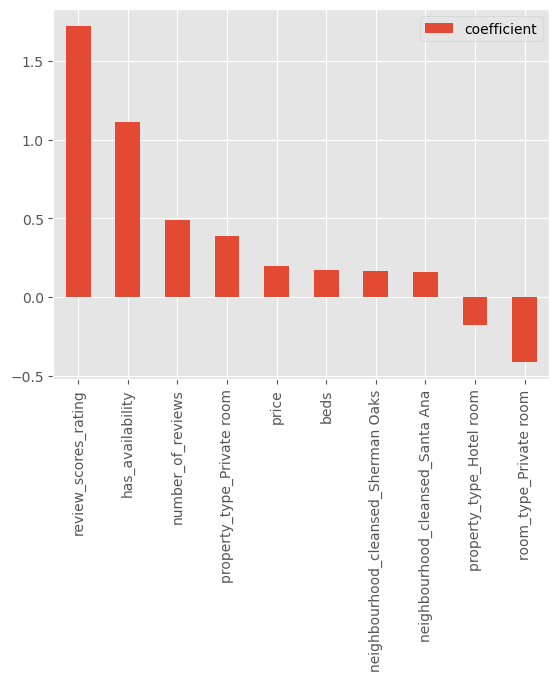

In [30]:
## feature importance for select features, (16 features with the highest positive and negative coefficients)
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = importance.plot(kind='bar')
plt.show()

Due to having several hundred features we narrowed down our search to 10 key features for predicting being a Superhost.

The requirements for being a Superhost as described by AirBnB are as follows:
Completed at least 10 trips or 3 reservations that total at least 100 nights
Maintained a 90% response rate or higher
Maintained a less than 1% cancellation rate, with exceptions made for those that fall under our Extenuating Circumstances policy
Maintained a 4.8 overall rating (A review counts towards Superhost status when either both the guest and the Host have submitted a review, or the 14-day window for reviews is over, whichever comes first).

The features we found that are the strongest in influencing the probability of becoming a Super Host are review_scores_rating, has_availability, number_of_reviews, property_type_Private room, price, beds, neighbourhood_cleansed_Sherman Oaks, neighbourhood_cleansed_Santa Ana, property_type_Hotel room, room_type_Private room. Review_scores_rating was the highest at 1.721785 and room_type_Private room is the lowest at -0.413266. This indicates that ratings are of utmost imporance in predicting a superhost. Additionally numbers of ratings, availablility, whether the listing is for a a private room, the price, number of beds and if it's in a desireable neighborhood such as Sherman Oaks or Santa Ana add influence to that as well. There are also 2 features that negatively affect the likelihood of having Suprerhost status, the type of property for the listing being a Hotel Room, and the the type of room for the listing being a private room.

Given the information we have on how AirBnB makes the determination to award Superhost status, it stands to reason that review scores would be the most influential feature. Additionally, we hypothesize that there are underlying reasons why has_availability proved to be highly influential, as underlying issues such as lack of maintenance, that could potentially limit the availability of a listing would also limit the listing's desirability and therefore reduce the likelihood of having Superhost status.

# Interpret Support Vectors



To begin, since we went with a stochastic gradient descent classified due to training time, we'll first look at the features that made up the most importance in that model.  After, we'll attempt to train a SVM Classsifier on a subsample of the original data to see if model performance is acceptable and the time to run component becomes more reasonable.

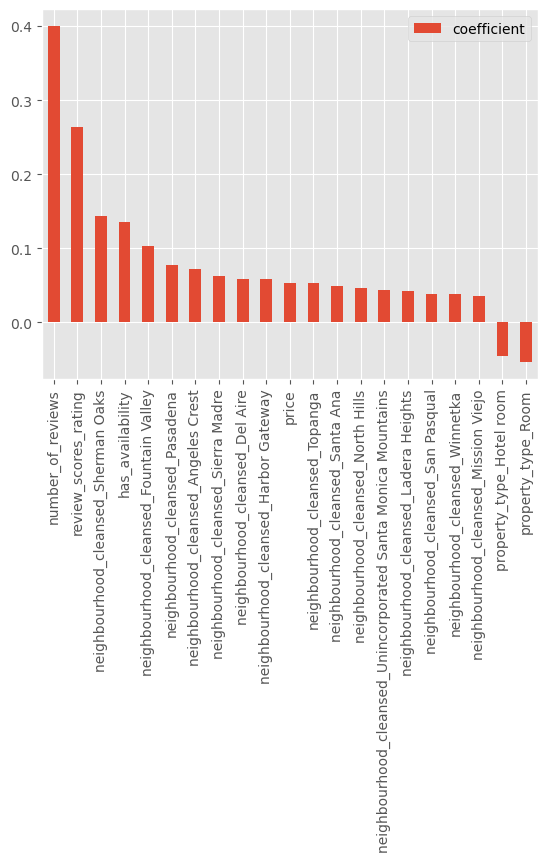

In [31]:
#SGD Feature importance 

# coefficient corresponds to the weights, since the data has been scaled (larger absolute values are features of most importance)
svmImportance = pd.DataFrame(svmSGD.coef_.transpose(),index= X.columns.values.tolist(), columns= ['coefficient']).sort_values(ascending=False, by = 'coefficient')
svmImportance = svmImportance[(svmImportance['coefficient']<-.035) | (svmImportance['coefficient']>.035)] # since we have so many variables, this takes the most important
svmImportance


## feature importance for select features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = svmImportance.plot(kind='bar')
plt.show()

#### Sub sampling the data set to attempt to train a SVC to identify the support vectors

Because we used an 80/20 train test split, I already have a 20% sub sample in the test.  I will use that as my 'start' sub sample and split that out into a new train test split and use that to train a SVC and identify the support vectors.



In [32]:
#creating a new train/test split using ONLY the test split from before - effectively using a 20% subsample of the data to train an SVC
#make copies of the test split into an X_sub, and y_sub for use in this model

from sklearn.svm import SVC
X_sub = X_test
y_sub = y_test

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub,y_sub, random_state=seed[0], train_size=.8, shuffle=True)#X_test/train is scaled since X_sc is used for X
    
svm_clf_sub = SVC(C=0.5,kernel='rbf',degree =3, gamma='auto', random_state=seed[0])
svm_clf_sub.fit(X_train_sub,y_train_sub.values.ravel())

y_hat_sub = svm_clf_sub.predict(X_test_sub)
acc = mt.accuracy_score(y_test_sub,y_hat_sub)
cm = mt.confusion_matrix(y_test_sub,y_hat_sub, labels=[1,0])
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')



Confusion Matrix
       True  False
True     60    325
False    43    796
________________________________
accuracy: 0.6993464052287581
sensitivity: 0.5825242718446602
specificity: 0.7100802854594113 



As mentioned above, we want to be able to analyze the support vectors used by a SVM on our data.  To do so, we made the decision to use a 20% subsample of our data.  Because we had already split out the data into an 80/20 training/testing split, we were able to use the test split, already 20%, as a feed into our SVM Classifier model.

We begin by creating a train/test split from that 20% subsample.  We then fit and predict on that mode.

This results in thg following model performance:

Confusion Matrix

|   | True | False |
| ---- | ----- | ---- |
| True | 60 | 325 |
| False | 43 | 796 |

________________________________
| Metric | Value |
| ---- | ---- |
| accuracy: | 0.6993464052287581 |
| sensitivity:| 0.5825242718446602 |
| specificity:|  0.7100802854594113  |

The results show that the performance is in line with the SGD and not too much below the SVC trained and tested with the full dataset.  However, the training time was 50 times less.  This alone gives support to the viability of this model.

Next, we'll look at the instances choosen as support vectors by the support vector classifier.

#### Look at the instances choosen as support vectors

Now that we have an SVM trained on a subsample of the data that is running in about 7 seconds, we will evaluate the instances that were chosen as support vectors.

In [33]:
#extract out the instances as support vectors and plot them
df_tested_on = df.iloc[X_train_sub.index.values,:].copy()
df_support = df_tested_on.iloc[svm_clf_sub.support_,:].copy()


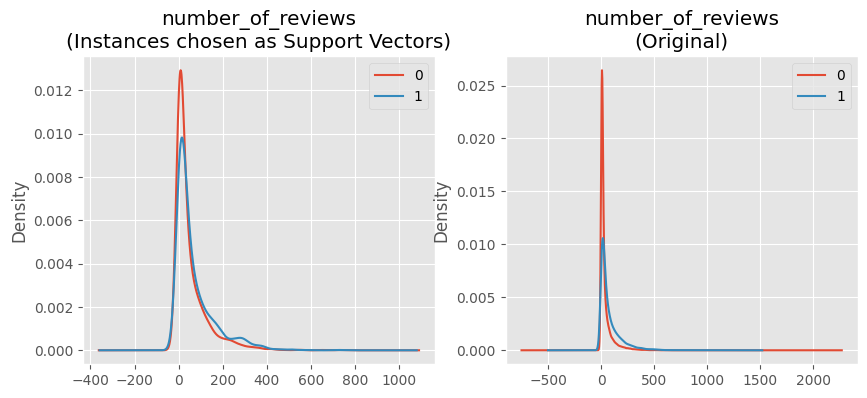

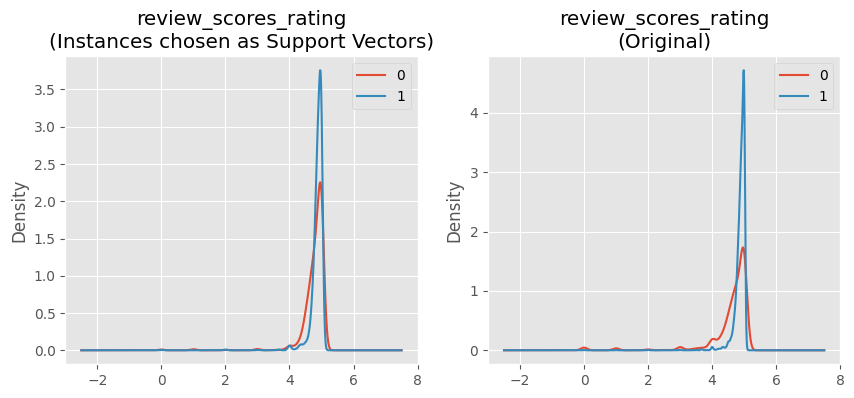

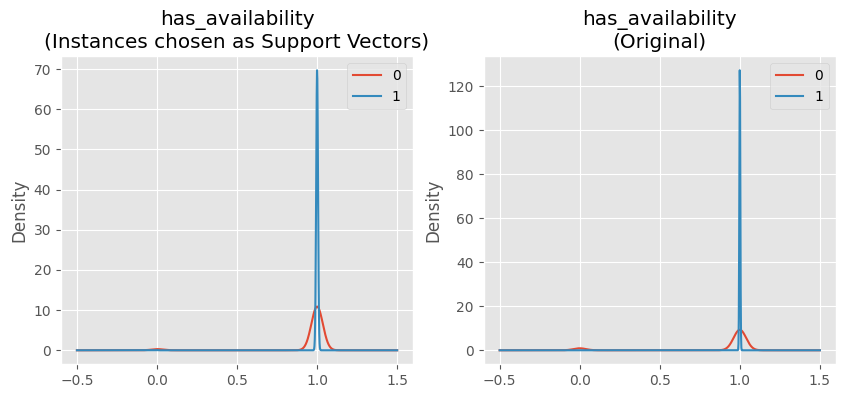

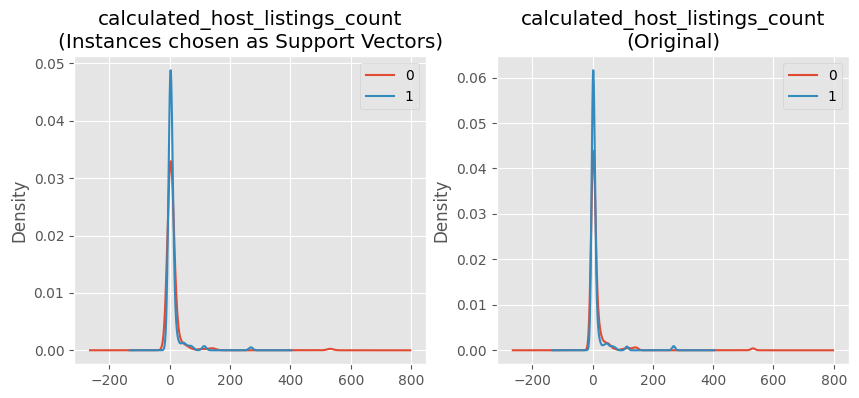

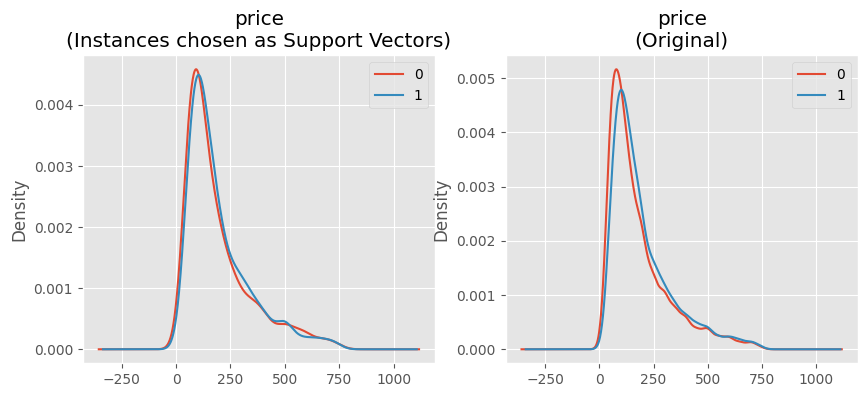

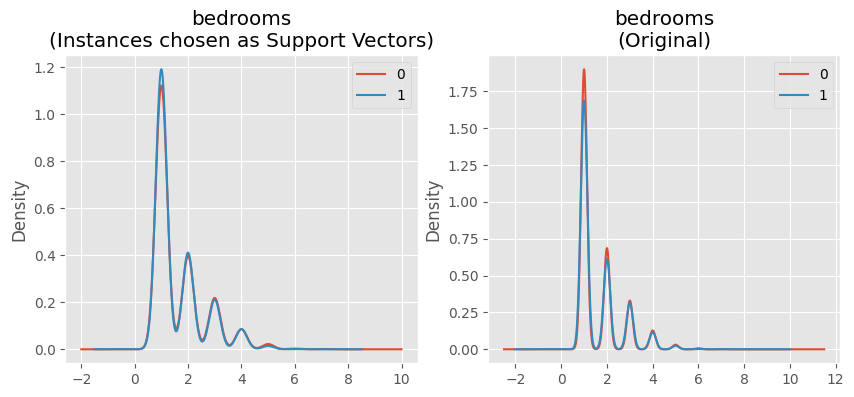

In [37]:
from pandas.plotting import boxplot
df_grouped_support = df_support.groupby(['host_is_superhost'])
df_grouped = df.groupby(['host_is_superhost'])

vars_to_plot = ['number_of_reviews','review_scores_rating','has_availability','calculated_host_listings_count','price','bedrooms']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend([0,1])
    plt.title(v+'\n(Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend([0,1])
    plt.title(v+'\n(Original)')


#### Evaluating support vectors of the Support Vector Machine Classifier trained on a subsample of the data

In the plots above, for a set of important features, we see on the left the original seperation in the distributions and on the right, that of the chosen support vectors.  We can see overall that the difference in seperation is less in the support vectors than in the original data set.

This is expected as the support vectors typically are chosen due to their similiarity, and they may have been predicted incorrectly by the training of the model.

Looking at the number of reviews and review score rating, our assumption is that super hosts would be more likely to have more listings with more frequent bookings, and therefore be more likely to have more ratings given as well, given that ratings play such a part in the ability to gain super host status, a higher overall rating score.